## Random Forest Classification

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

#### 1. Khai báo 1 số hàm trực quan 

In [107]:
def _plot_time_series(y_act, y_pred, dates, title="", xlabel="Time", ylabel="Value"):
    plt.figure(figsize=(14, 8))
    plt.plot(dates, y_act, 'r-o', label="Actual Value")
    plt.plot(dates, y_pred, '--', label="Predicted Value")

    y_min = min(np.min(y_act), np.min(y_pred))
    y_max = max(np.max(y_act), np.max(y_pred))
    plt.axis([dates[0], dates[-1], y_min*0.95, y_max*1.05])

    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(fontsize=16)
    plt.title(title, fontsize=20)
    plt.xticks(dates[::10], fontsize=16, rotation=45)  # Xoay ngày để tránh chồng chéo
    plt.tight_layout()  # Đảm bảo không bị cắt bớt nhãn
    plt.show()    

# Function to plot scatter plot between actual and predicted values
def scatter_plot_act_pred(y_act, y_pred, title="", xlabel="", ylabel=""):
    plt.figure(figsize=(14, 8))
    plt.scatter(range(len(y_act)), y_act, c='r', marker='o', label="Actual values")
    plt.scatter(range(len(y_pred)), y_pred, c='b', marker='s', label="Predicted values")
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(fontsize=15)
    plt.title(title, fontsize=20)
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=20)
    plt.colorbar()
    plt.xlabel('Predicted labels', fontsize=16)
    plt.ylabel('True labels', fontsize=16)
    plt.xticks(np.arange(cf_matrix.shape[1]), labels=np.arange(cf_matrix.shape[1]))
    plt.yticks(np.arange(cf_matrix.shape[0]), labels=np.arange(cf_matrix.shape[0]))

    thresh = cf_matrix.max() / 2.
    for i, j in itertools.product(range(cf_matrix.shape[0]), range(cf_matrix.shape[1])):
        plt.text(j, i, format(cf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cf_matrix[i, j] > thresh else "black")
    
    plt.show()


#### 2. Chọn đặc trưng 

##### 2.1 Đọc dữ liệu

- Tập train

In [108]:
df = pd.read_csv("TransformedData.csv")
df = df.drop(columns=['AQI-IN'])
df.head()

,Date,PM2.5,PM10,SO2,NO2,O3,CO,Temp,Humidity,AQI_Label
0,2021-04-08,4.127394,4.521907,2.644121,3.333478,5.567764,23.280893,-0.354070,6.633250,1.0
1,2021-04-09,4.941693,5.062635,2.491780,3.638278,6.244998,24.859606,-0.264799,6.244998,2.0
2,2021-04-10,4.736275,4.969862,2.094713,3.466711,6.480741,24.331050,0.003014,6.480741,2.0
3,2021-04-11,4.127394,4.820347,1.818446,2.893444,6.708204,16.822604,0.092285,6.855655,1.0
4,2021-04-12,3.527224,3.951613,1.443635,2.776472,6.403124,26.832816,-0.175528,8.306624,0.0


- Tập test

In [109]:
df_test = pd.read_csv("TransformedDataTest.csv")
df_test = df_test.drop(columns=['AQI-IN'])
df_test.head()

,Date,PM2.5,PM10,SO2,NO2,CO,Temp,Humidity,AQI_Label
0,2024-04-08,2.998223,5.429365,0.881374,2.491780,10.000000,-2.039323,4.358899,2.0
1,2024-04-09,4.897895,5.135833,2.094713,3.333478,16.822604,-2.353065,3.872983,2.0
2,2024-04-10,5.036995,5.123999,2.491780,3.466711,19.570386,-1.725581,5.916080,2.0
3,2024-04-11,4.912709,5.123999,1.443635,3.093102,21.610183,-0.784355,7.810250,2.0
4,2024-04-12,4.304248,4.969862,1.443635,2.776472,20.000000,-0.156871,7.280110,1.0


##### 2.2 Biến đầu vào

- Tập train

In [110]:
x = df[['PM2.5', 'PM10', 'SO2', 'NO2', 'Temp']]
x.head()

,PM2.5,PM10,SO2,NO2,Temp
0,4.127394,4.521907,2.644121,3.333478,-0.354070
1,4.941693,5.062635,2.491780,3.638278,-0.264799
2,4.736275,4.969862,2.094713,3.466711,0.003014
3,4.127394,4.820347,1.818446,2.893444,0.092285
4,3.527224,3.951613,1.443635,2.776472,-0.175528


- Tập test

In [111]:
x_test = df_test[['PM2.5', 'PM10', 'SO2', 'NO2', 'Temp']]
x_test.head()

,PM2.5,PM10,SO2,NO2,Temp
0,2.998223,5.429365,0.881374,2.491780,-2.039323
1,4.897895,5.135833,2.094713,3.333478,-2.353065
2,5.036995,5.123999,2.491780,3.466711,-1.725581
3,4.912709,5.123999,1.443635,3.093102,-0.784355
4,4.304248,4.969862,1.443635,2.776472,-0.156871


##### 2.3 Biến mục tiêu

- Tập train

In [112]:
y = df[['AQI_Label']]
y.head()

,AQI_Label
0,1.0
1,2.0
2,2.0
3,1.0
4,0.0


- Tập test

In [113]:
y_test = df_test[['AQI_Label']]
y_test.head()

,AQI_Label
0,2.0
1,2.0
2,2.0
3,2.0
4,1.0


##### 2.4 Chia thành 2 tập train và tập validation

<li>Chọn giá trị random_state cho hàm chia tập dữ liệu</li>

In [114]:
# random_states = range(1, 200)
# mean_scores = []
# for random_state in random_states:
#     scores = []
#     for _ in range(5): 
#         X_train, X_validation, y_train, y_validation = train_test_split(x, y, test_size=0.2, random_state=random_state)
#         model = LogisticRegression()
#         model.fit(X_train, y_train)
#         score = model.score(X_validation, y_validation)
#         scores.append(score)
#     mean_scores.append(np.mean(scores))

# best_random_state = random_states[np.argmax(mean_scores)]
# print("Best random state:", best_random_state)

<li>Chia dữ liệu</li>

In [115]:
X_train, X_validation, y_train, y_validation = train_test_split(x, y, test_size=0.2, random_state=186)
print(X_train.shape, X_validation.shape)
print(y_train.shape, y_validation.shape)
y_train = y_train.values.ravel()
y_validation = y_validation.values.ravel()
y_test = y_test.values.ravel()


(876, 5) (220, 5)
(876, 1) (220, 1)


#### 3. Huấn luyện mô hình

##### 3.1 Tạo một đối tượng mô hình hồi quy tuyến tính từ thư viện linear_model và huấn luyện nó với biến đầu vào và biến mục tiêu

In [116]:
randomForest_model = RandomForestClassifier(
                        n_estimators=100,
                        criterion='gini', 
                        max_depth=None, 
                        min_samples_split=2, 
                        min_samples_leaf=1, 
                        max_features=None,
                        max_leaf_nodes=None, 
                        min_impurity_decrease=0.0, 
                        bootstrap=True, 
                        oob_score=False,
                        max_samples=None
                    )
randomForest_model.fit(X_train, y_train)

RandomForestClassifier(max_features=None)

##### 3.2 Dự đoán giá trị AQI-IN

<li>Trên tập train</li>

In [117]:
ypred_train = randomForest_model.predict(X_train)
ypred_train

array([1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1.,
       1., 3., 0., 1., 0., 1., 0., 0., 2., 0., 0., 2., 1., 0., 2., 1., 1.,
       0., 0., 3., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 2., 0., 2., 0., 2., 0., 1., 1., 0., 0., 0., 2., 1., 1.,
       0., 3., 0., 1., 0., 2., 1., 2., 0., 1., 0., 1., 1., 0., 2., 1., 0.,
       0., 0., 2., 0., 2., 0., 1., 1., 2., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 2., 2., 1., 0.,
       1., 2., 0., 2., 0., 1., 1., 1., 1., 1., 1., 0., 0., 2., 1., 1., 2.,
       1., 1., 1., 0., 1., 2., 1., 1., 1., 0., 0., 1., 1., 2., 0., 1., 0.,
       0., 2., 1., 0., 2., 0., 1., 0., 2., 1., 2., 0., 0., 1., 1., 1., 3.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 2., 0., 1.,
       0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 2., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 2., 2., 0., 0., 0.,
       1., 0., 1., 1., 1.

<li>Dự đoán trên tập validation</li>

In [118]:
ypred_validation = randomForest_model.predict(X_validation)
ypred_validation

array([0., 1., 1., 1., 0., 1., 3., 1., 1., 1., 0., 2., 1., 1., 2., 0., 1.,
       0., 2., 0., 1., 0., 0., 1., 0., 0., 1., 1., 2., 1., 0., 0., 0., 2.,
       0., 1., 3., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
       1., 1., 0., 2., 0., 0., 1., 2., 0., 1., 0., 0., 2., 1., 0., 1., 0.,
       2., 1., 0., 0., 0., 2., 2., 1., 0., 2., 0., 1., 3., 4., 1., 0., 1.,
       0., 1., 3., 0., 0., 1., 0., 0., 2., 0., 0., 1., 1., 0., 0., 3., 0.,
       0., 1., 0., 3., 0., 1., 0., 1., 1., 2., 2., 1., 0., 0., 2., 0., 0.,
       0., 2., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 3., 0., 0.,
       0., 1., 0., 0., 1., 0., 3., 0., 1., 1., 2., 0., 0., 1., 0., 3., 0.,
       2., 0., 1., 2., 0., 1., 0., 0., 0., 2., 0., 1., 0., 1., 0., 1., 2.,
       2., 1., 0., 0., 2., 0., 0., 0., 0., 1., 2., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 4., 0., 1., 0., 2., 1., 0., 2., 0., 0., 1., 0., 2., 0.,
       0., 0., 2., 3., 0., 0., 0., 2., 1., 0., 1., 1., 2., 0., 2., 0.])

- Tập test

In [119]:
ypred_test = randomForest_model.predict(x_test)
ypred_test

array([2., 2., 2., 2., 1., 0., 0., 3., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 2., 2.,
       0., 1., 1., 0., 1., 1., 1., 0., 0., 1.])

#### 4. Đánh giá mô hình

##### 4.1 Accuracy

<li>Tập train</li>

In [120]:
accuracy_score(list(y_train), list(ypred_train))

1.0

<li>Tập validation</li>

In [121]:
accuracy_score(list(y_validation), list(ypred_validation))

0.8772727272727273

- Tập test

In [122]:
accuracy_score(list(y_test), list(ypred_test))

0.9318181818181818

##### 4.2 Recall 

<li>Tập train</li>

In [123]:
recall = recall_score(y_train, ypred_train, average='weighted')
print('Recall:', recall)

Recall: 1.0


<li>Tập validation</li>

In [124]:
recall = recall_score(y_validation, ypred_validation, average='weighted')
print('Recall:', recall)

Recall: 0.8772727272727273


- Tập test

In [125]:
recall = recall_score(y_test, ypred_test, average='weighted')
print('Recall:', recall)

Recall: 0.9318181818181818


##### 4.3 F1-score là một số liệu đánh giá hiệu suất mô hình phân loại dựa trên precision và recall. Nó là một phép đo tổng hợp hữu ích khi các lớp trong tập dữ liệu có tỷ lệ phân phối không đồng đều. Trong trường hợp có sự mất cân bằng giữa các lớp, F1-score weighted cung cấp một cái nhìn tổng quát về hiệu suất của mô hình trên toàn bộ dữ liệu.


<li>Tâp Train</li>

In [126]:
f1 = f1_score(y_train, ypred_train, average='weighted')
print('F1-score:', f1)

F1-score: 1.0


<li>Tập validation</li>

In [127]:
f1 = f1_score(y_validation, ypred_validation, average='weighted')
print('F1-score:', f1)

F1-score: 0.8753082697622132


- Tập test

In [128]:
f1 = f1_score(y_test, ypred_test, average='weighted')
print('F1-score:', f1)

F1-score: 0.9320724729815638


##### 4.4 Trực quan sự chênh lệch đặc trưng AQI-IN giữa giá trị ban đầu và giá trị được dự đoán 

- Ma trận nhầm lẫn tập train và tập validation

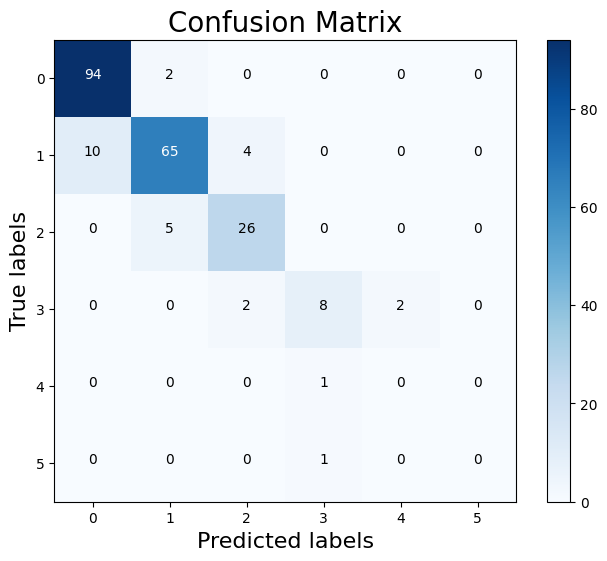

In [129]:
plot_confusion_matrix(y_validation, ypred_validation)

- Ma trận nhầm lẫn tập train và tập test

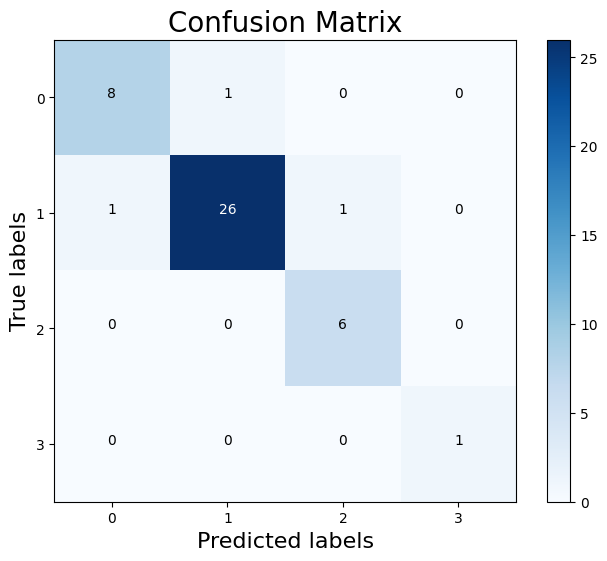

In [130]:
plot_confusion_matrix(y_test, ypred_test)

- Tập validation

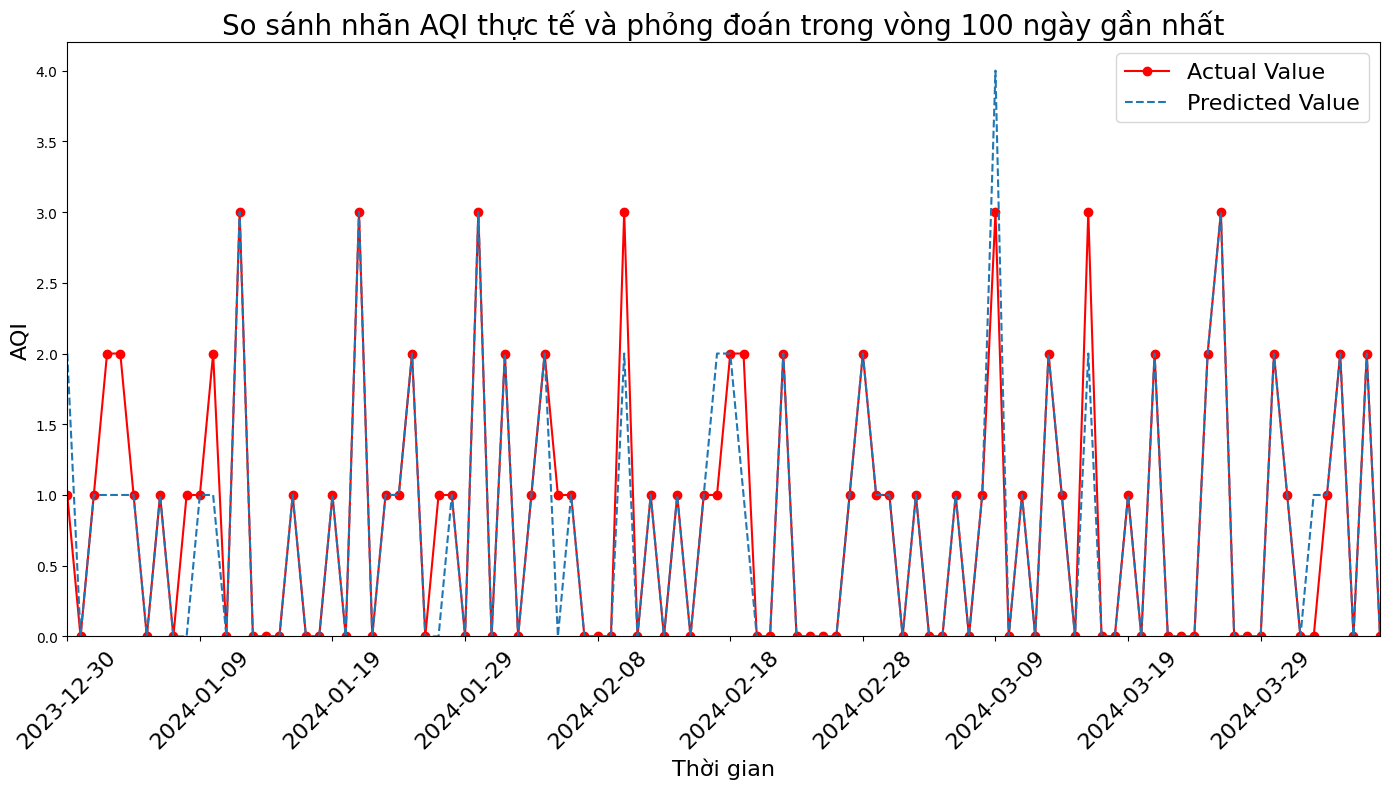

In [131]:
_plot_time_series(y_validation[-100:], ypred_validation[-100:], df['Date'][-100:].values, 
                  title='So sánh nhãn AQI thực tế và phỏng đoán trong vòng 100 ngày gần nhất',  
                  xlabel='Thời gian', 
                  ylabel='AQI')

- Tập test

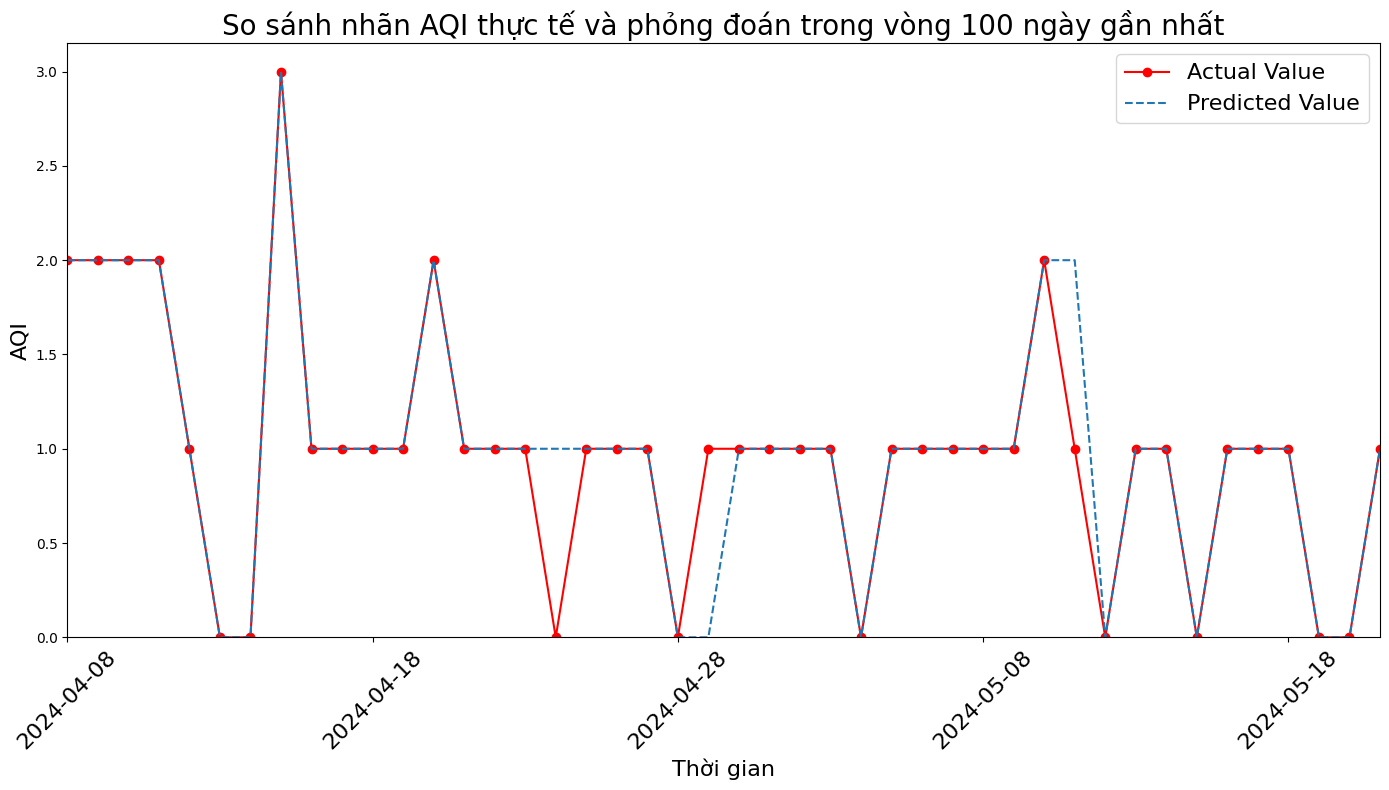

In [132]:
_plot_time_series(y_test, ypred_test, df_test['Date'].values, 
                  title='So sánh nhãn AQI thực tế và phỏng đoán trong vòng 100 ngày gần nhất',  
                  xlabel='Thời gian', 
                  ylabel='AQI')

#### 5. Kết luận